In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# disable pandas warning
pd.options.mode.chained_assignment = None

# ***COMPARE CLEAN & NOISY***

In [2]:
clean_data_60 = pd.read_csv('clean_data_60_fps.csv')
noisy_data_60 = pd.read_csv('noisy_data_60_fps.csv')

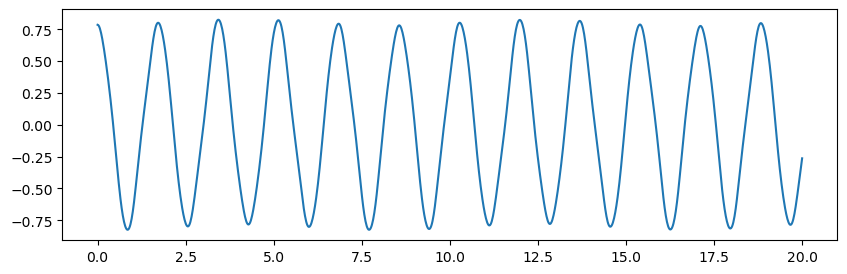

In [3]:
# plot theta vs time
plt.figure(figsize=(10, 3))
plt.plot(clean_data_60['t'], clean_data_60['theta'], label='clean data')
plt.show()

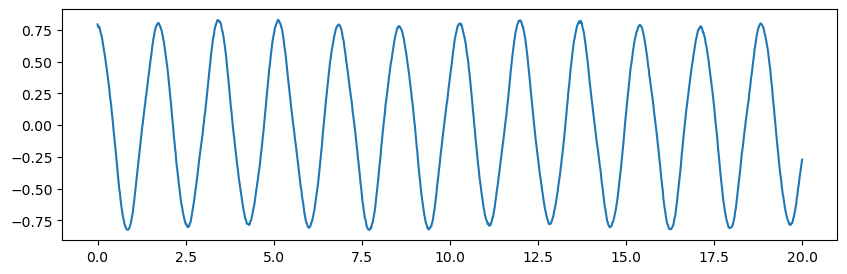

In [4]:
# plot noisy data
plt.figure(figsize=(10, 3))
plt.plot(noisy_data_60['t'], noisy_data_60['theta'], label='noisy data')
plt.show()

# **CLEAN DATA**

In [5]:
# load data_60_fps.csv
clean_data_60 = pd.read_csv('clean_data_60_fps.csv')
clean_data_60.head()

,t,z,theta,dz,dtheta,ddz,ddtheta,x_64,y_64
0,0.0000,0.500000,0.785398,0.000000,0.000000,6.936718,-13.873435,54.627417,41.372583
1,0.0165,0.500971,0.783456,0.114043,-0.228077,6.859709,-13.715785,54.627289,41.284650
2,0.0330,0.503806,0.777787,0.225633,-0.451126,6.635088,-13.259341,54.625472,41.027449
3,0.0500,0.508612,0.768178,0.335475,-0.670761,6.250480,-12.516790,54.617414,40.589899
4,0.0665,0.515002,0.755395,0.434649,-0.870109,5.731296,-11.590464,54.596699,40.004976


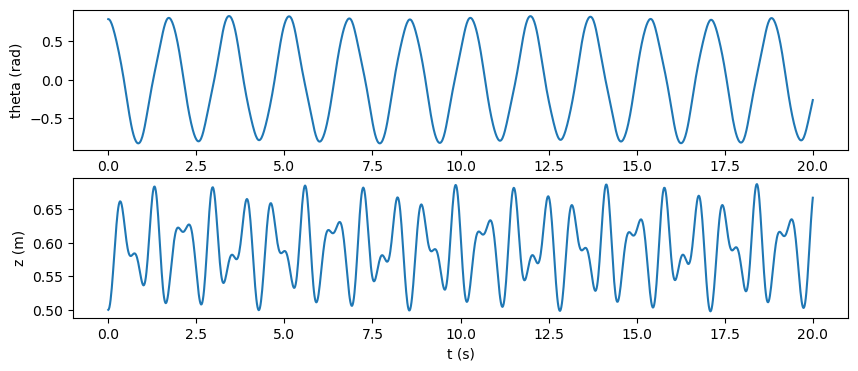

In [6]:
# plot theta and z against t (in seconds), in two subplots 2 rows, 1 column
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(clean_data_60['t'], clean_data_60['theta'])
plt.ylabel('theta (rad)')
plt.subplot(2, 1, 2)
plt.plot(clean_data_60['t'], clean_data_60['z'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.show()

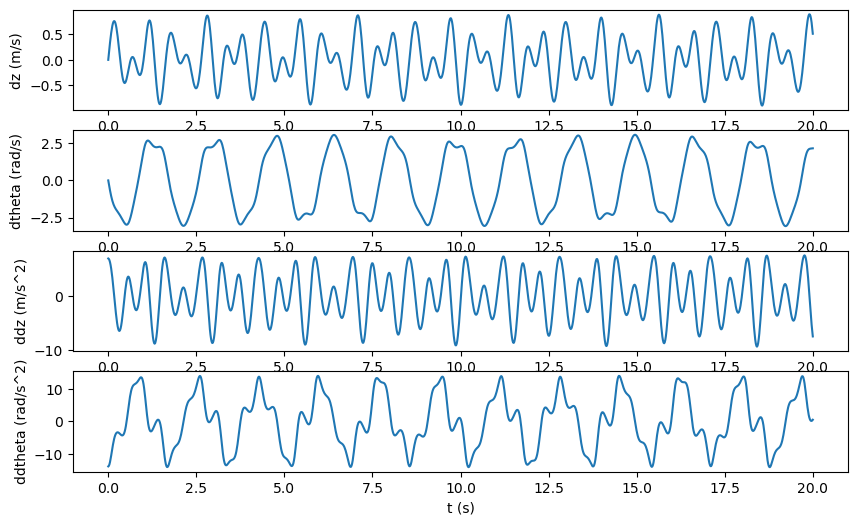

In [7]:
# plot dz, dtheta, ddz, ddtheta against t (in seconds), in two subplots 2 rows, 1 column
plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(clean_data_60['t'], clean_data_60['dz'])
plt.ylabel('dz (m/s)')
plt.subplot(4, 1, 2)
plt.plot(clean_data_60['t'], clean_data_60['dtheta'])
plt.ylabel('dtheta (rad/s)')
plt.subplot(4, 1, 3)
plt.plot(clean_data_60['t'], clean_data_60['ddz'])
plt.ylabel('ddz (m/s^2)')
plt.subplot(4, 1, 4)
plt.plot(clean_data_60['t'], clean_data_60['ddtheta'])
plt.ylabel('ddtheta (rad/s^2)')
plt.xlabel('t (s)')
plt.show()

## Assuming we can only observe t, z, theta

### since data is clean, we can simply take the dz, dtheta, ddz, ddtheta

In [8]:
# known data being z and theta
known_data = clean_data_60[['t', 'z', 'theta']]

# infer dt
known_data['dt'] = known_data['t'].diff()
# infer dz and dtheta from z and theta
known_data['dz'] = known_data['z'].diff()
known_data['dtheta'] = known_data['theta'].diff()
# infer ddz and ddtheta from dz and dtheta
known_data['ddz'] = known_data['dz'].diff()
known_data['ddtheta'] = known_data['dtheta'].diff()

# drop nan in known_data
known_data = known_data.iloc[20:-20]

In [9]:
# from clean data:
known_data.head(3)

,t,z,theta,dt,dz,dtheta,ddz,ddtheta
20,0.3335,0.661663,0.280041,0.0170,0.001538,-0.039259,-0.001740,-0.002165
21,0.3500,0.661406,0.240878,0.0165,-0.000257,-0.039163,-0.001795,0.000096
22,0.3665,0.659515,0.200623,0.0165,-0.001891,-0.040254,-0.001634,-0.001091


## See if we can recover dynamics from numerical derivatives.

$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

In [10]:
verify_zdotdot_df = known_data[['z']]
verify_zdotdot_df['dotdotz'] = known_data['ddz'] / (known_data['dt']**2)
verify_zdotdot_df['z*(thetadot^2)'] = known_data['z'] * ((known_data['dtheta']/known_data['dt'])**2)
verify_zdotdot_df['cos(theta)'] = np.cos(known_data['theta'])
verify_zdotdot_df.head(3)

,z,dotdotz,z*(thetadot^2),cos(theta)
20,0.661663,-6.021720,3.528800,0.961044
21,0.661406,-6.594393,3.726145,0.971129
22,0.659515,-6.000198,3.925391,0.979943


In [11]:
X = verify_zdotdot_df[['z*(thetadot^2)', 'cos(theta)', 'z']]
y = verify_zdotdot_df['dotdotz']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for z*(thetadot^2)
print(' coefficient for z*(thetadot^2) = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for cos(theta)
print(' coefficient for cos(theta) = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))
# print coefficient for z
print(' coefficient for z = ' , round(model.params[3],4), ' ± ', round(2*model.bse[3],4))

 coefficient for intercept =  59.3596  ±  1.0952
 coefficient for z*(thetadot^2) =  1.036  ±  0.1149
 coefficient for cos(theta) =  8.3966  ±  2.2348
 coefficient for z =  -117.0482  ±  2.2613


$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

In [12]:
verify_thetadotdot_df = known_data[['theta']]
verify_thetadotdot_df['thetadotdot'] = known_data['ddtheta'] / (known_data['dt']**2)
verify_thetadotdot_df['sin(theta)/z'] = np.sin(known_data['theta']) / known_data['z']
verify_thetadotdot_df['zdot*thetadot/z'] = (known_data['dz'] / known_data['dt']) * (known_data['dtheta'] / known_data['dt']) / known_data['z']
verify_thetadotdot_df.head(3)

,theta,thetadotdot,sin(theta)/z,zdot*thetadot/z
20,0.280041,-7.490622,0.417728,-0.315798
21,0.240878,0.352931,0.360679,0.055932
22,0.200623,-4.007427,0.302162,0.423886


In [13]:
X = verify_thetadotdot_df[['sin(theta)/z', 'zdot*thetadot/z']]
y = verify_thetadotdot_df['thetadotdot']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for sin(theta)/z
print(' coefficient for sin(theta)/z = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for zdot*thetadot/z
print(' coefficient for zdot*thetadot/z = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))

 coefficient for intercept =  -0.0141  ±  0.1865
 coefficient for sin(theta)/z =  -9.7771  ±  0.2285
 coefficient for zdot*thetadot/z =  -1.9863  ±  0.1394


$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

## **Clean Data ODE Recovery Success**

### We are basically able to extract the right dynamics at 60 fps on clean data using numerical diff.

------------------------------------------------------------------------
------------------------------------------------------------------------

# **NOISY DATA**

## **Convolution for smoothing**

In [14]:
# load noisy_data_60_fps.csv
noisy_data_60 = pd.read_csv('noisy_data_60_fps.csv')

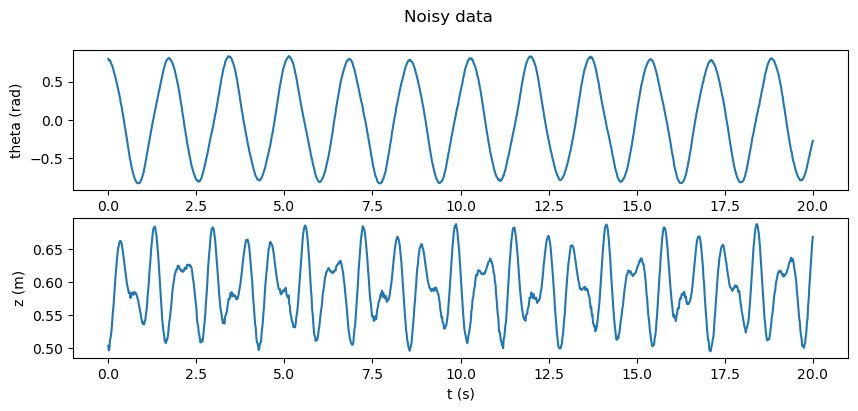

In [15]:
# known data being z and theta
known_data = noisy_data_60[['t', 'z', 'theta']]

# plot theta and z against t (in seconds), in two subplots 2 rows, 1 column
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.plot(known_data['t'], known_data['theta'])
plt.ylabel('theta (rad)')
plt.subplot(2, 1, 2)
plt.plot(known_data['t'], known_data['z'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.suptitle('Noisy data')
plt.show()

In [16]:
import torch
from torch.distributions import Normal
from torch.nn import functional as F

In [17]:
def gaussian_kernel_1d(sigma: float, num_sigmas: float = 3.) -> torch.Tensor:
    radius = (num_sigmas * sigma) // 1
    support = torch.arange(-radius, radius + 1, dtype=torch.float)
    kernel = Normal(loc=0, scale=sigma).log_prob(support).exp_()
    return kernel.mul_(1 / kernel.sum()).reshape(1, 1, -1).double()

In [18]:
SIGMA_1 = 3
kernel = gaussian_kernel_1d(SIGMA_1, 3)
kernel.shape

torch.Size([1, 1, 19])

In [19]:
lim = kernel.shape.numel()//2
pad = (lim, lim)

### Smoothing raw data for $1^{st}$ derivative calculations

In [20]:
zs = known_data['z'].values
thetas = known_data['theta'].values

ztensor = torch.tensor(zs).reshape(1, 1, -1)
thetatensor = torch.tensor(thetas).reshape(1, 1, -1)

zs_pad = F.pad(ztensor, pad, mode='replicate')
thetas_pad = F.pad(thetatensor, pad, mode='replicate')

zs_smooth = F.conv1d(zs_pad, kernel)
thetas_smooth = F.conv1d(thetas_pad, kernel)

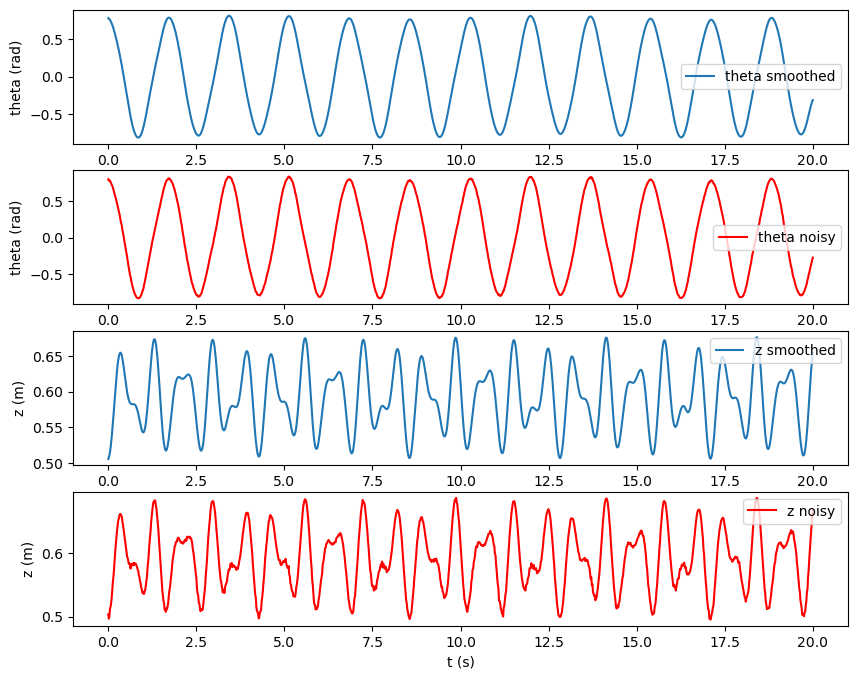

In [21]:
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(known_data['t'], thetas_smooth[0,0,:])
plt.legend(['theta smoothed'])
plt.ylabel('theta (rad)')
plt.subplot(4, 1, 2)
plt.plot(known_data['t'], known_data['theta'], 'r')
plt.legend(['theta noisy'])
plt.ylabel('theta (rad)')
plt.xlabel('t (s)')
plt.subplot(4, 1, 3)
plt.plot(known_data['t'], zs_smooth[0,0,:])
plt.legend(['z smoothed'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.subplot(4, 1, 4)
plt.plot(known_data['t'], known_data['z'], 'r')
plt.legend(['z noisy'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.show()

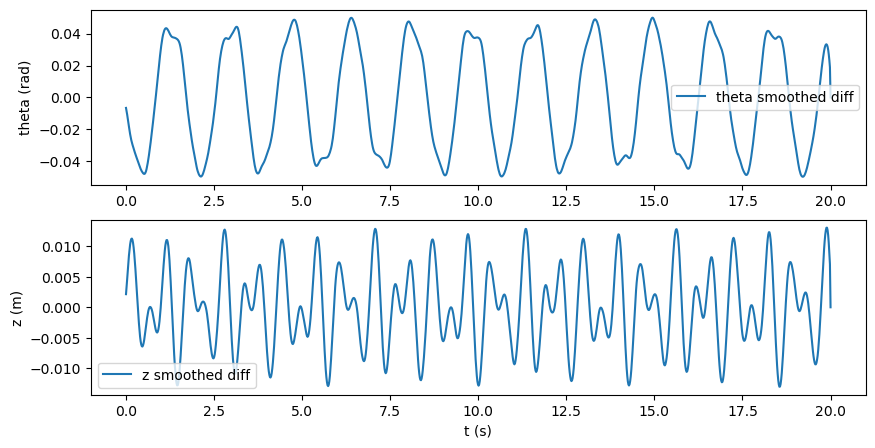

In [22]:
pad = (0,1)
zs_smooth_pad = F.pad(zs_smooth, pad, mode='replicate')
thetas_smooth_pad = F.pad(thetas_smooth, pad, mode='replicate')

zs_smooth_diff = zs_smooth_pad.diff()
thetas_smooth_diff = thetas_smooth_pad.diff()

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(known_data['t'], thetas_smooth_diff[0,0,:])
plt.legend(['theta smoothed diff'])
plt.ylabel('theta (rad)')
plt.subplot(2, 1, 2)
plt.plot(known_data['t'], zs_smooth_diff[0,0,:])
plt.legend(['z smoothed diff'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.show()


In [23]:
SIGMA_1 = 2
kernel = gaussian_kernel_1d(SIGMA_1, 3)

lim = kernel.shape.numel()//2
pad = (lim, lim)

zs_smooth_diff_pad = F.pad(zs_smooth_diff, pad, mode='replicate')
thetas_smooth_diff_pad = F.pad(thetas_smooth_diff, pad, mode='replicate')

zs_smooth_diff_smooth = F.conv1d(zs_smooth_diff_pad, kernel)
thetas_smooth_diff_smooth = F.conv1d(thetas_smooth_diff_pad, kernel)

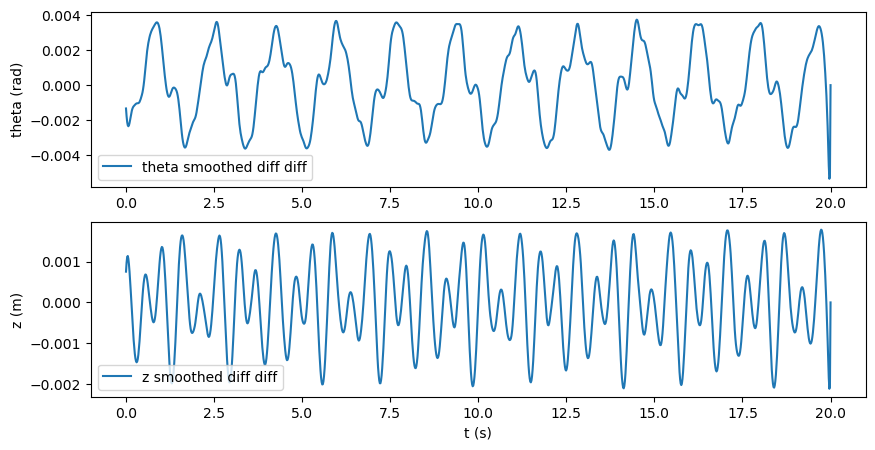

In [24]:
pad = (0,1)
zs_smooth_diff_pad = F.pad(zs_smooth_diff_smooth, pad, mode='replicate')
thetas_smooth_diff_pad = F.pad(thetas_smooth_diff_smooth, pad, mode='replicate')

zs_smooth_diff_diff = zs_smooth_diff_pad.diff()
thetas_smooth_diff_diff = thetas_smooth_diff_pad.diff()

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.plot(known_data['t'], thetas_smooth_diff_diff[0,0,:])
plt.legend(['theta smoothed diff diff'])
plt.ylabel('theta (rad)')
plt.subplot(2, 1, 2)
plt.plot(known_data['t'], zs_smooth_diff_diff[0,0,:])
plt.legend(['z smoothed diff diff'])
plt.ylabel('z (m)')
plt.xlabel('t (s)')
plt.show()

In [25]:
known_data.head()

,t,z,theta
0,0.0000,0.503508,0.793951
1,0.0165,0.496661,0.774548
2,0.0330,0.500221,0.770576
3,0.0500,0.512739,0.776394
4,0.0665,0.515649,0.754480


In [26]:
# infer dt
known_data['dt'] = known_data['t'].diff()

# fill in dz, dtheta, ddz, ddtheta
known_data['dz'] = zs_smooth_diff[0,0,:]
known_data['dtheta'] = thetas_smooth_diff[0,0,:]
known_data['ddz'] = zs_smooth_diff_diff[0,0,:]
known_data['ddtheta'] = thetas_smooth_diff_diff[0,0,:]

# drop first 20 rows and last 20 rows
known_data = known_data.iloc[20:-20]
known_data.head()

,t,z,theta,dt,dz,dtheta,ddz,ddtheta
20,0.3335,0.661808,0.285284,0.0170,0.000247,-0.039736,-0.001386,-0.001036
21,0.3500,0.661868,0.233687,0.0165,-0.001236,-0.040772,-0.001280,-0.001030
22,0.3665,0.659725,0.195477,0.0165,-0.002609,-0.041851,-0.001132,-0.001008
23,0.3840,0.657408,0.165231,0.0175,-0.003819,-0.042926,-0.000949,-0.000961
24,0.3995,0.651621,0.112648,0.0155,-0.004823,-0.043973,-0.000740,-0.000889


### is it too different??? **YES :(**
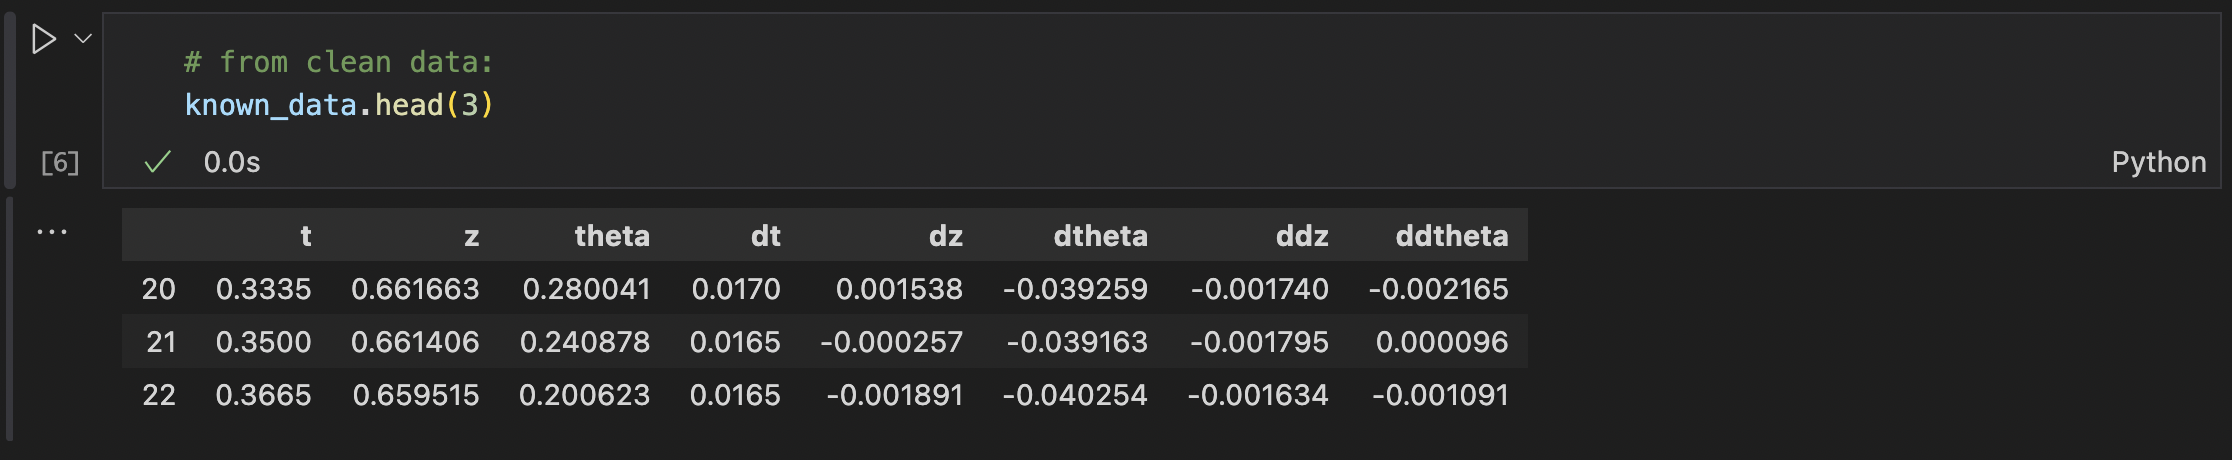

$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

In [27]:
verify_zdotdot_df = known_data[['z']]
verify_zdotdot_df['dotdotz'] = known_data['ddz'] / (known_data['dt']**2)
verify_zdotdot_df['z*(thetadot^2)'] = known_data['z'] * ((known_data['dtheta']/known_data['dt'])**2)
verify_zdotdot_df['cos(theta)'] = np.cos(known_data['theta'])

# remove nan
verify_zdotdot_df = verify_zdotdot_df.dropna()
# remove inf
verify_zdotdot_df = verify_zdotdot_df[verify_zdotdot_df['dotdotz'] != np.inf]

In [28]:
X = verify_zdotdot_df[['z*(thetadot^2)', 'cos(theta)', 'z']]
y = verify_zdotdot_df['dotdotz']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for z*(thetadot^2)
print(' coefficient for z*(thetadot^2) = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for cos(theta)
print(' coefficient for cos(theta) = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))
# print coefficient for z
print(' coefficient for z = ' , round(model.params[3],4), ' ± ', round(2*model.bse[3],4))

 coefficient for intercept =  48.1337  ±  0.7983
 coefficient for z*(thetadot^2) =  0.6792  ±  0.081
 coefficient for cos(theta) =  7.0253  ±  1.4769
 coefficient for z =  -94.4023  ±  1.4356


$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

### Some terms are not correctly recovered, most basically right

$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

In [29]:
verify_thetadotdot_df = known_data[['theta']]
verify_thetadotdot_df['thetadotdot'] = known_data['ddtheta'] / (known_data['dt']**2)
verify_thetadotdot_df['sin(theta)/z'] = np.sin(known_data['theta']) / known_data['z']
verify_thetadotdot_df['zdot*thetadot/z'] = (known_data['dz'] / known_data['dt']) * (known_data['dtheta'] / known_data['dt']) / known_data['z']

# remove nan
verify_thetadotdot_df = verify_thetadotdot_df.dropna()
# remove inf
verify_thetadotdot_df = verify_thetadotdot_df[verify_thetadotdot_df['thetadotdot'] != np.inf]

In [30]:
X = verify_thetadotdot_df[['sin(theta)/z', 'zdot*thetadot/z']]
y = verify_thetadotdot_df['thetadotdot']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for sin(theta)/z
print(' coefficient for sin(theta)/z = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for zdot*thetadot/z
print(' coefficient for zdot*thetadot/z = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))

 coefficient for intercept =  0.0145  ±  0.0475
 coefficient for sin(theta)/z =  -9.2815  ±  0.059
 coefficient for zdot*thetadot/z =  -1.7464  ±  0.0416


$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

### **Conv Smoothing NOT TOO GOOD...**

## **Spline for Smoothing**

In [31]:
# load noisy_data_60_fps.csv
noisy_data_60 = pd.read_csv('noisy_data_60_fps.csv')

# known data being z and theta
known_data = noisy_data_60[['t', 'z', 'theta']]

len(known_data)

1200

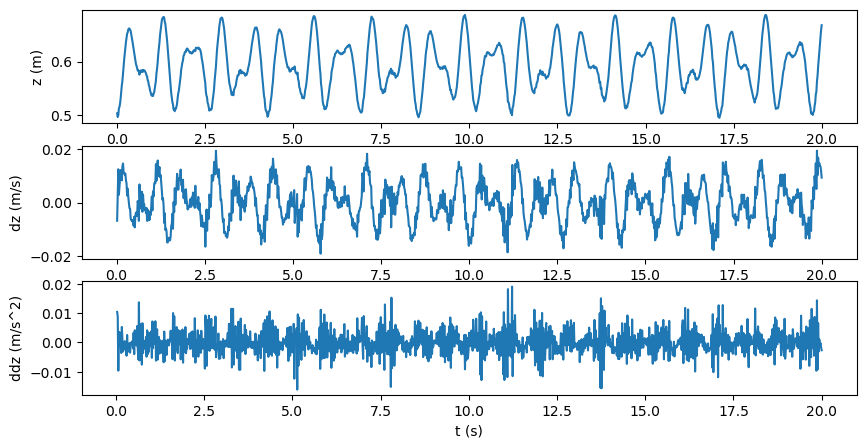

In [32]:
z_noisy = torch.tensor(known_data['z'].values).float().unsqueeze(0).unsqueeze(0)
dz_noisy = z_noisy.diff()
ddz_noisy = dz_noisy.diff()

# plot z, dz ddz against t (in seconds), in three subplots 3 rows, 1 column
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(known_data['t'], z_noisy[0,0,:])
plt.ylabel('z (m)')
plt.subplot(3, 1, 2)
plt.plot(known_data['t'][1:], dz_noisy[0,0,:])
plt.ylabel('dz (m/s)')
plt.subplot(3, 1, 3)
plt.plot(known_data['t'][2:], ddz_noisy[0,0,:])
plt.ylabel('ddz (m/s^2)')
plt.xlabel('t (s)')
plt.show()

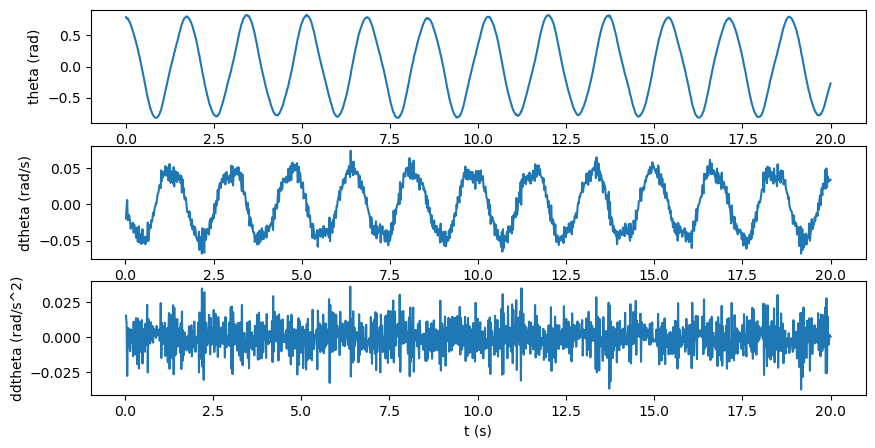

In [33]:
theta_noisy = torch.tensor(known_data['theta'].values).float().unsqueeze(0).unsqueeze(0)
dtheta_noisy = theta_noisy.diff()
ddtheta_noisy = dtheta_noisy.diff()
# plot theta, dtheta ddtheta against t (in seconds), in three subplots 3 rows, 1 column
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(known_data['t'], theta_noisy[0,0,:])
plt.ylabel('theta (rad)')
plt.subplot(3, 1, 2)
plt.plot(known_data['t'][1:], dtheta_noisy[0,0,:])
plt.ylabel('dtheta (rad/s)')
plt.subplot(3, 1, 3)
plt.plot(known_data['t'][2:], ddtheta_noisy[0,0,:])
plt.ylabel('ddtheta (rad/s^2)')
plt.xlabel('t (s)')
plt.show()

In [34]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.pipeline import make_pipeline

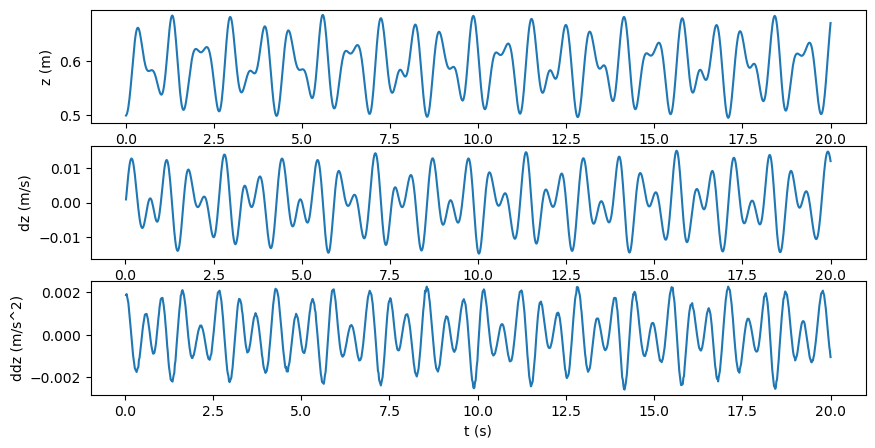

In [35]:
z_degree = 6
z_n_knots = 100
spline_model_z = make_pipeline(SplineTransformer(n_knots=z_n_knots, degree=z_degree, 
                                                 extrapolation='continue'), 
                               Ridge(alpha=1e-3))
spline_model_z.fit(known_data['t'].values.reshape(-1, 1), known_data['z'].values.reshape(-1, 1))
z_spline = spline_model_z.predict(known_data['t'].values.reshape(-1, 1))
dz = z_spline[1:] - z_spline[:-1]

dz_degree = 6
dz_n_knots = 100
spline_model_dz = make_pipeline(SplineTransformer(n_knots=dz_n_knots, degree=dz_degree,
                                                    extrapolation='continue'),
                                Ridge(alpha=1e-3))
spline_model_dz.fit(known_data['t'].values.reshape(-1, 1)[1:], dz)
dz_spline = spline_model_dz.predict(known_data['t'].values.reshape(-1, 1)[1:])
dz_spline = np.insert(dz_spline, 0, np.nan)

ddz_spline = dz_spline[1:] - dz_spline[:-1]
ddz_spline = np.insert(ddz_spline, 0, np.nan)

# plot z spline, dz spline, ddz spline against t (in seconds), in four subplots 3 rows, 1 column
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(known_data['t'], z_spline)
plt.ylabel('z (m)')
plt.subplot(3, 1, 2)
plt.plot(known_data['t'], dz_spline)
plt.ylabel('dz (m/s)')
plt.subplot(3, 1, 3)
plt.plot(known_data['t'], ddz_spline)
plt.ylabel('ddz (m/s^2)')
plt.xlabel('t (s)')
plt.show()

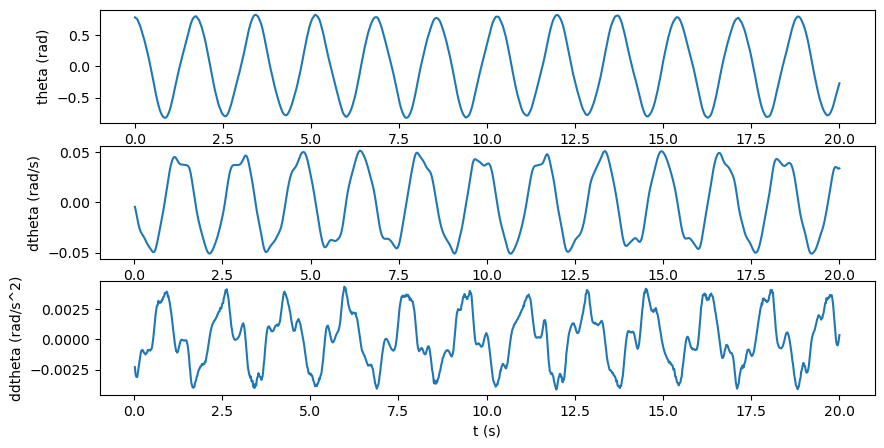

In [36]:
theta_degree = 6
theta_n_knots = 500
spline_model_theta = make_pipeline(SplineTransformer(n_knots=theta_n_knots, degree=theta_degree, 
                                                     extrapolation='continue'), 
                                    Ridge(alpha=1e-3))
spline_model_theta.fit(known_data['t'].values.reshape(-1, 1), known_data['theta'].values.reshape(-1, 1))
theta_spline = spline_model_theta.predict(known_data['t'].values.reshape(-1, 1))

dtheta = theta_spline[1:] - theta_spline[:-1]
dtheta_degree = 6
dtheta_n_knots = 200
spline_model_dtheta = make_pipeline(SplineTransformer(n_knots=dtheta_n_knots, degree=dtheta_degree,
                                                        extrapolation='continue'),
                                    Ridge(alpha=1e-3))
spline_model_dtheta.fit(known_data['t'].values.reshape(-1, 1)[1:], dtheta)
dtheta_spline = spline_model_dtheta.predict(known_data['t'].values.reshape(-1, 1)[1:])
dtheta_spline = np.insert(dtheta_spline, 0, np.nan)

ddtheta_spline = dtheta_spline[1:] - dtheta_spline[:-1]
ddtheta_spline = np.insert(ddtheta_spline, 0, np.nan)

# plot theta spline, dtheta spline, ddtheta spline against t (in seconds), in four subplots 3 rows, 1 column
plt.figure(figsize=(10, 5))
plt.subplot(3, 1, 1)
plt.plot(known_data['t'], theta_spline)
plt.ylabel('theta (rad)')
plt.subplot(3, 1, 2)
plt.plot(known_data['t'], dtheta_spline)
plt.ylabel('dtheta (rad/s)')
plt.subplot(3, 1, 3)
plt.plot(known_data['t'], ddtheta_spline)
plt.ylabel('ddtheta (rad/s^2)')
plt.xlabel('t (s)')
plt.show()

In [37]:
# infer dt
known_data['dt'] = known_data['t'].diff()

# fill in dz, dtheta, ddz, ddtheta
known_data['dz'] = dz_spline
known_data['dtheta'] = dtheta_spline
known_data['ddz'] = ddz_spline
known_data['ddtheta'] = ddtheta_spline

# drop first 20 rows and last 20 rows
known_data = known_data.iloc[20:-20]
known_data.head(3)

,t,z,theta,dt,dz,dtheta,ddz,ddtheta
20,0.3335,0.661808,0.285284,0.0170,0.001451,-0.038821,-0.001744,-0.001256
21,0.3500,0.661868,0.233687,0.0165,-0.000196,-0.040005,-0.001647,-0.001184
22,0.3665,0.659725,0.195477,0.0165,-0.001752,-0.041117,-0.001556,-0.001112


### is it too different??? **YES :(**
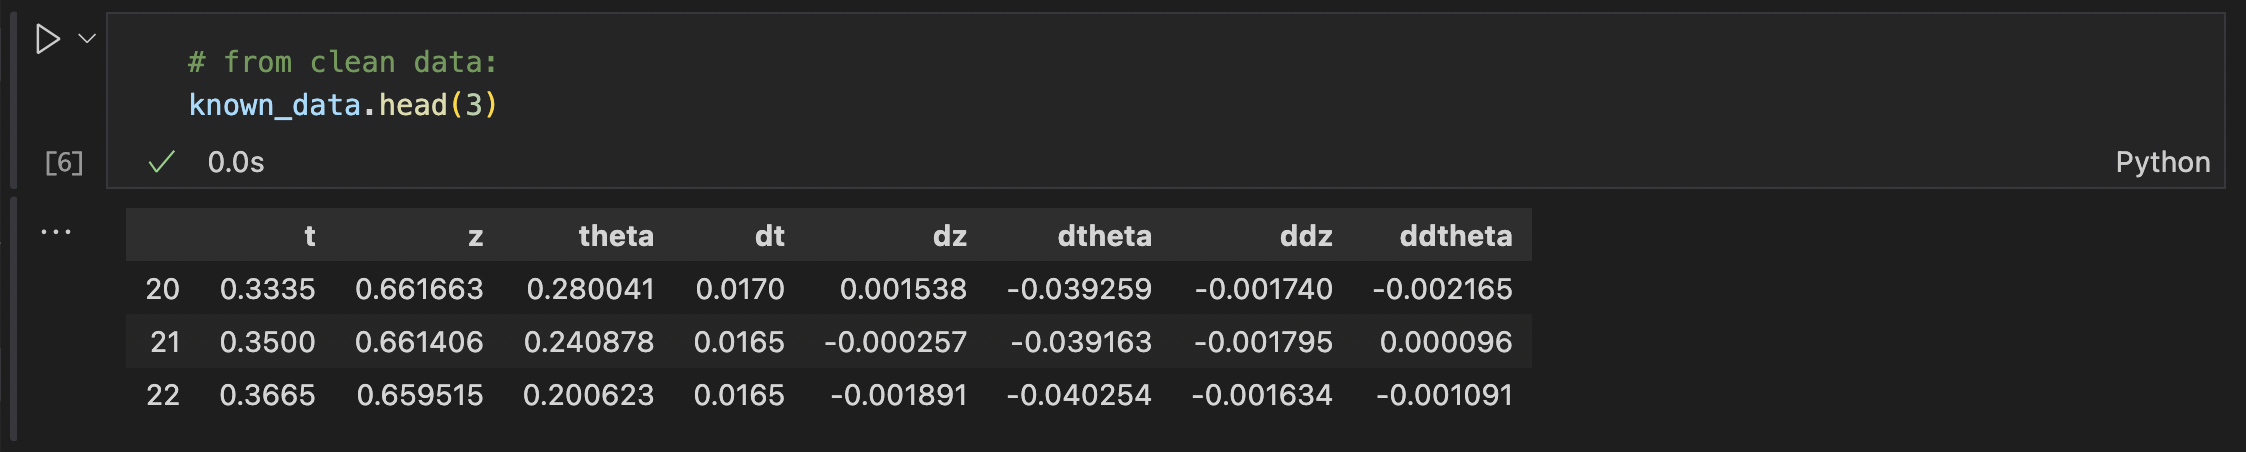

$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

In [38]:
verify_zdotdot_df = known_data[['z']]
verify_zdotdot_df['dotdotz'] = known_data['ddz'] / (known_data['dt']**2)
verify_zdotdot_df['z*(thetadot^2)'] = known_data['z'] * ((known_data['dtheta']/known_data['dt'])**2)
verify_zdotdot_df['cos(theta)'] = np.cos(known_data['theta'])

# remove nan
verify_zdotdot_df = verify_zdotdot_df.dropna()
# remove inf
verify_zdotdot_df = verify_zdotdot_df[verify_zdotdot_df['dotdotz'] != np.inf]

In [39]:
X = verify_zdotdot_df[['z*(thetadot^2)', 'cos(theta)', 'z']]
y = verify_zdotdot_df['dotdotz']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for z*(thetadot^2)
print(' coefficient for z*(thetadot^2) = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for cos(theta)
print(' coefficient for cos(theta) = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))
# print coefficient for z
print(' coefficient for z = ' , round(model.params[3],4), ' ± ', round(2*model.bse[3],4))

 coefficient for intercept =  56.7317  ±  0.9444
 coefficient for z*(thetadot^2) =  0.7811  ±  0.0965
 coefficient for cos(theta) =  11.5851  ±  1.893
 coefficient for z =  -116.1025  ±  1.9921


$$
\ddot{z} = z \dot{\theta}^{2} + g \cos \theta - \frac{k}{m} z + \frac{kl}{m} = 60 + 1 \cdot (z \dot{\theta}^{2}) + 9.81 \cdot (\cos \theta) - 120 \cdot (z)
$$

### Some not correct, all basically right...

$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

In [40]:
verify_thetadotdot_df = known_data[['theta']]
verify_thetadotdot_df['thetadotdot'] = known_data['ddtheta'] / (known_data['dt']**2)
verify_thetadotdot_df['sin(theta)/z'] = np.sin(known_data['theta']) / known_data['z']
verify_thetadotdot_df['zdot*thetadot/z'] = (known_data['dz'] / known_data['dt']) * (known_data['dtheta'] / known_data['dt']) / known_data['z']

# remove nan
verify_thetadotdot_df = verify_thetadotdot_df.dropna()
# remove inf
verify_thetadotdot_df = verify_thetadotdot_df[verify_thetadotdot_df['thetadotdot'] != np.inf]

In [41]:
X = verify_thetadotdot_df[['sin(theta)/z', 'zdot*thetadot/z']]
y = verify_thetadotdot_df['thetadotdot']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
# print coefficient for intercept
print(' coefficient for intercept = ' , round(model.params[0],4), ' ± ', round(2*model.bse[0],4))
# print coefficient for sin(theta)/z
print(' coefficient for sin(theta)/z = ' , round(model.params[1],4), ' ± ', round(2*model.bse[1],4))
# print coefficient for zdot*thetadot/z
print(' coefficient for zdot*thetadot/z = ' , round(model.params[2],4), ' ± ', round(2*model.bse[2],4))

 coefficient for intercept =  -0.0203  ±  0.0606
 coefficient for sin(theta)/z =  -9.8497  ±  0.0749
 coefficient for zdot*thetadot/z =  -2.0566  ±  0.0466


$$
\ddot{\theta} = -g \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
 = -9.81 \frac{\sin \theta}{z} - 2 \frac{\dot{z} \dot{\theta}}{z}
$$

### Spline smoothing recovery better than convolution smoothing